In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from gravity_model.utils import pickleLoad, getVoronoiPolygons
from gravity_model.Gravity import GravityModel

from sttn.data.lehd import OriginDestinationEmploymentDataProvider
lehd_provider = OriginDestinationEmploymentDataProvider()

In [2]:
path = 'data/'
CG = pickleLoad(path + 'boston_network.pickle')
coords = pickleLoad(path + 'boston_citynode_attributes.pickle')

lehd_polygons = lehd_provider.get_data(state='ma', year=2018).nodes.loc[coords.keys()]

In [3]:
G = nx.DiGraph()
G.add_weighted_edges_from([(e[0], e[1], e[2]['S000']) for e in CG.edges(data = True)])
nodepop = dict(G.out_degree(weight="weight")); nodepop = dict((n, nodepop[n]) for n in G.nodes())
nodepop2 = dict(G.in_degree(weight="weight")); nodepop2 = dict((n, nodepop2[n]) for n in G.nodes())

mean_lat = np.mean([lat for lon, lat, _ in coords.values()]).round()
sx = np.cos(np.pi / 180 * mean_lat)
nodexy = np.array([[coords[n][0] * sx, coords[n][1]] for n in G.nodes()])

A = nx.to_numpy_array(G)

In [4]:
lehd_polygons = lehd_polygons.join(pd.Series(nodepop2).rename('pop'), on='id')

/media/a/e/venvs/common_venv/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


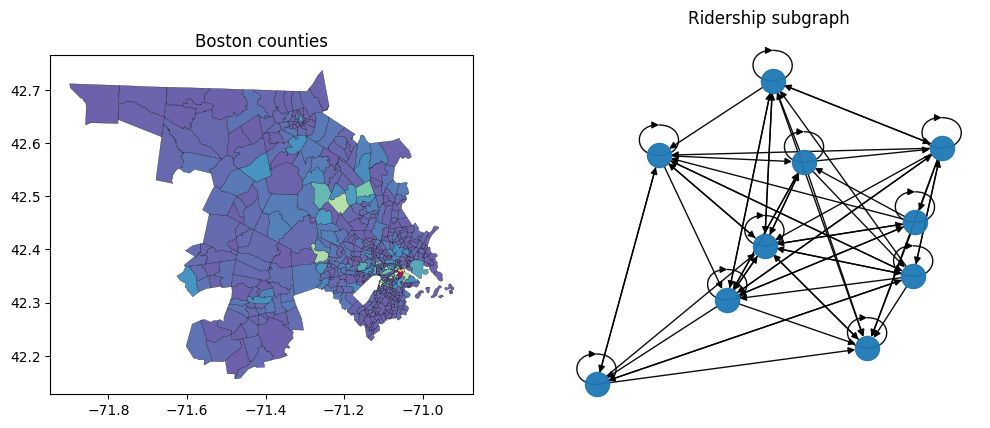

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title('Boston counties')
lehd_polygons.plot(column='pop', cmap='Spectral_r', alpha=0.9, ax=axes[0], edgecolor='black', linewidth=0.2)

random_nodes = G.subgraph(nodes=np.random.choice(lehd_polygons.index, 10, replace=False))
nx.draw_kamada_kawai(random_nodes, ax=axes[1], alpha=0.95)
axes[1].set_title('Ridership subgraph')

plt.show()

In [20]:
# Instantiate and fit model
model = GravityModel(
    locations = nodexy, 
    initial_alpha = 1.0, 
    weights = np.fromiter(nodepop2.values(), dtype=float), 
    populations = np.fromiter(nodepop.values(), dtype=float), 
    fine_tune_locations = False, 
    lossType = 'binomialB1', 
    dpow = 2
    )

model.fit(true_flows = A, steps = 500, learning_rate = 0.1, edgebatching = 0) 

Initial loss = 5.309092098028641, Alpha = 1.0
Step 100: Loss = 5.157252270011331, Alpha = 9.99085521697998
Step 200: Loss = 5.094113683346785, Alpha = 16.525484085083008
Step 300: Loss = 5.068771618088862, Alpha = 21.10370445251465
Step 400: Loss = 5.05897601206895, Alpha = 24.199438095092773
Step 500: Loss = 5.055413115446981, Alpha = 26.204580307006836


In [21]:
# Finetune locations
model2 = GravityModel(
    locations = nodexy, 
    initial_alpha = model.alpha.item(), 
    weights = np.fromiter(nodepop2.values(), dtype=float), 
    populations = np.fromiter(nodepop.values(), dtype=float), 
    fine_tune_locations = True, 
    lossType = 'binomialB1', 
    dpow = 2)

model2.fit(true_flows = A, steps = 1000, learning_rate = 0.0003, edgebatching = 0) #, batch_size = 1000

Initial loss = 5.055393299576011, Alpha = 26.204580307006836
Step 100: Loss = 5.017964846146043, Alpha = 26.234270095825195
Step 200: Loss = 5.003569363338467, Alpha = 26.259262084960938
Step 300: Loss = 4.9985907771652025, Alpha = 26.276878356933594
Step 400: Loss = 4.997075814946074, Alpha = 26.287248611450195
Step 500: Loss = 4.996592490592117, Alpha = 26.292795181274414
Step 600: Loss = 4.996426999982902, Alpha = 26.295686721801758
Step 700: Loss = 4.996368119913743, Alpha = 26.297203063964844
Step 800: Loss = 4.996347276589216, Alpha = 26.298009872436523
Step 900: Loss = 4.996340206345237, Alpha = 26.2984561920166
Step 1000: Loss = 4.996337966579879, Alpha = 26.29867935180664


<Axes: >

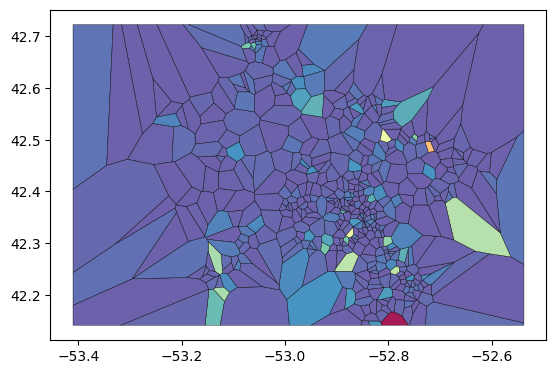

In [40]:
redefiend_nodexy = model2.locations.detach().data.numpy()
voronoi_projected = getVoronoiPolygons(redefiend_nodexy, lehd_polygons, column='pop')
voronoi_projected.plot(column='pop', cmap='Spectral_r', alpha=0.9, edgecolor='black', linewidth=0.3)